<center> <h2>Sentiment Analysis of Twitter Data for predicting Stock Price

__Introduction:__ This rpoject involves evaluation TESLA's social media data and uses sentiment classification to estimate its future stock trend. We employed sentiment analysis and machine learning principles to estimate the impact of "public sentiment" on "market fluctuations."

### Import Required Python Packages

In [53]:
import pandas as pd
import numpy as np
import requests
from flask import Response
import re

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

from matplotlib import rcParams
rcParams['figure.figsize'] = 12, 6
import matplotlib.pyplot as plt
plt.style.use('ggplot')


from sklearn.metrics import *
import warnings
warnings.filterwarnings("ignore")

In [2]:
from Scweet.scweet import scrape
from Scweet.user import get_user_information, get_users_following, get_users_followers

In [3]:
import flair
sentiment_model = flair.models.TextClassifier.load('en-sentiment')

2021-11-10 02:41:34,974 loading file C:\Users\fahad\.flair\models\sentiment-en-mix-distillbert_4.pt


### Scweet Python Scraper

In [4]:
# Python API allows to scrape only 7 days of data in free tier, So we managed to use Scweet tweets scraper to get tweets data for one year, 
#that can scrape the data between two given dates
#data = scrape(words=['tesla'], since="2020-10-31", until="2021-10-31",interval=1, 
 #    headless=True, display_type="Top")

In [5]:
# data saved to csv file after scraping
#data.to_csv('scraped_data.csv', index = False)

In [7]:
data = pd.read_csv('scraped_data.csv')
data.head()

,UserScreenName,UserName,Timestamp,Text,Embedded_text,Emojis,Comments,Likes,Retweets,Image link,Tweet URL
0,East Bay Tesla Club | Fremont |,@TeslaOwnersEBay,2020-10-31T23:10:55.000Z,East Bay Tesla Club | Fremont |\n@TeslaOwnersE...,Happy Halloween all you \n@Tesla\n Freaks!\n...,👻 🎃,5,40,399,['https://pbs.twimg.com/media/ElsYJB5U0AAQjOY?...,https://twitter.com/TeslaOwnersEBay/status/132...
1,Kim Paquette,@kimpaquette,2020-10-31T21:02:45.000Z,Kim Paquette\n@kimpaquette\n·\n1 Nov 2020,Guess what I am for Halloween! #FSDBeta #Tes...,💫 🦄 🎃 🤓,150,46,1.1K,['https://pbs.twimg.com/media/Elr6zZ_XYAAbIDj?...,https://twitter.com/kimpaquette/status/1322645...
2,Dogs of Tesla,@dogsoftesla,2020-10-31T21:58:30.000Z,Dogs of Tesla\n@dogsoftesla\n·\n1 Nov 2020,F R A N K I E \n\nHappy Halloween! \n\n#Tesla...,✨ 💜 💜 ✨ 👻,10,21,152,['https://pbs.twimg.com/media/ElsHitAUYAAjt6q?...,https://twitter.com/dogsoftesla/status/1322659...
3,Luke,@tweetoflbc,2020-10-31T22:54:04.000Z,Luke\n@tweetoflbc\n·\n1 Nov 2020,Major vibes anyone know whose this is? #tesla...,🔥,2,4,48,['https://pbs.twimg.com/media/ElsUR_kU4AEWl-L?...,https://twitter.com/tweetoflbc/status/13226732...
4,Randy 'DUO' Mongenel,@RandyMongenel,2020-10-31T20:22:41.000Z,Randy 'DUO' Mongenel\n@RandyMongenel\n·\n1 Nov...,One of the more interesting decals I've seen o...,NaN,2,NaN,5,['https://pbs.twimg.com/media/Elrxnj-UcAAAERw?...,https://twitter.com/RandyMongenel/status/13226...


#### Select only the Date and Text of speech from scraped data

In [8]:
import datetime
data['date'] = pd.to_datetime(data['Timestamp']).dt.date
df = data[['date', 'Embedded_text']]
df.head(20)

,date,Embedded_text
0,2020-10-31,Happy Halloween all you \n@Tesla\n Freaks!\n...
1,2020-10-31,Guess what I am for Halloween! #FSDBeta #Tes...
2,2020-10-31,F R A N K I E \n\nHappy Halloween! \n\n#Tesla...
3,2020-10-31,Major vibes anyone know whose this is? #tesla...
4,2020-10-31,One of the more interesting decals I've seen o...
5,2020-10-31,Just realized that even with the dozen or so F...
6,2020-10-31,How did you get a hold of that Chester? Thank ...
7,2020-10-31,Our #sociallydistanced #trickortreat solution....
8,2020-10-31,zombie apocalypse happen i’m stealing a tesla\...
9,2020-10-31,Demand problem Natick Massachusetts . You know...


#### Combine the tweets for each date in same rows.

In [9]:
df['Embedded_text'] = df.groupby('date')[['Embedded_text']].transform(lambda x : ' '.join(x))
df = df.drop_duplicates().reset_index().drop('index', axis = 1)
df.head()

,date,Embedded_text
0,2020-10-31,Happy Halloween all you \n@Tesla\n Freaks!\n...
1,2020-11-01,Is this the first Tesla in the country?\n118\n...
2,2020-11-02,Tesla Model Y is here! And quality is pretty d...
3,2020-11-03,I like that the Tesla maps now identify inters...
4,2020-11-04,Hey Tesla take me to Kinoo\n\nAutopilot :\n3\n...


#### Sentiment Analysis
  - Flair
  - Analyzing Tesla Tweets

In [10]:
# function to clean tweet text by removing links, special characters using simple regex statements
def clean_tweet(tweet):
    """ Utility . """
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+://\S+)", " ", tweet).split())

__Note:__ We'll be using the flair library's pre-trained sentiment analysis model.
This model divides the text into character-level tokens and makes predictions using the DistilBERT model.
Working at the character level (rather than the word level) has the advantage of allowing the network to attribute a feeling to words it has never encountered before.

In [11]:
probs = []
sentiments = []

for tweet in df['Embedded_text'].to_list():
    # make prediction
    tweet = clean_tweet(tweet)
    sentence = flair.data.Sentence(tweet)
    sentiment_model.predict(sentence)
    #extract sentiment prediction
    probs.append(sentence.labels[0].score)  # numerical score 0-1
    sentiments.append(sentence.labels[0].value)  # 'POSITIVE' or 'NEGATIVE'

# add probability and sentiment predictions to tweets dataframe
df['probability'] = probs
df['sentiment'] = sentiments

In [12]:
tweet_prob = df[['date', 'probability', 'sentiment']]
tweet_prob['date'] = pd.to_datetime(tweet_prob['date']) # convert string date object to datetime object

### Use Textblob to calculate polarity  parameter from the tweet text

In [13]:
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer

polarity = 0
tweet_polarity = []
 
 #print(tweet.text)
for tweet in df['Embedded_text'].to_list():
    analysis = TextBlob(tweet)
    score = SentimentIntensityAnalyzer().polarity_scores(tweet)
    polarity = analysis.sentiment.polarity
    tweet_polarity.append(polarity)

In [14]:
tweet_prob['tweet_polarity'] =  tweet_polarity

__Inference:__ We can observe from the above results flair model has created the positive and negative sentiments for compiled tweets of each day of last one year.

In [16]:
# The yahoo finance API is not working fine to scrape the data, so we direclty 
# downloaded one year of data from https://finance.yahoo.com/quote/TSLA/

tesla = pd.read_csv('tsla.csv')
tesla['Date'] = pd.to_datetime(tesla['Date']) # convert string date object to datetime object
tesla

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-02-11,394.000000,406.980011,392.299988,400.510010,400.510010,29021100
1,2020-03-11,409.730011,427.769989,406.690002,423.899994,423.899994,34351700
2,2020-04-11,430.619995,435.399994,417.100006,420.980011,420.980011,32143100
3,2020-05-11,428.299988,440.000000,424.000000,438.089996,438.089996,28414500
4,2020-06-11,436.100006,436.570007,424.279999,429.950012,429.950012,21706000
...,...,...,...,...,...,...,...
246,2021-10-25,950.530029,1045.020020,944.200012,1024.859985,1024.859985,62852100
247,2021-10-26,1024.689941,1094.939941,1001.440002,1018.429993,1018.429993,62415000
248,2021-10-27,1039.660034,1070.880005,1030.780029,1037.859985,1037.859985,38526500
249,2021-10-28,1068.310059,1081.000000,1054.199951,1077.040039,1077.040039,27213200


In [17]:
df_merged = pd.merge(left=tweet_prob, right=tesla, left_on='date', right_on='Date')
df_merged

,date,probability,sentiment,tweet_polarity,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-11-11,0.821078,POSITIVE,0.150447,2020-11-11,416.450012,418.700012,410.579987,417.130005,417.130005,17357700
1,2020-11-12,0.942596,NEGATIVE,0.217726,2020-11-12,615.010010,624.000000,596.799988,609.989990,609.989990,46475000
2,2020-11-13,0.999725,NEGATIVE,0.092293,2020-11-13,410.850006,412.529999,401.660004,408.500000,408.500000,19771100
3,2020-11-16,0.998980,POSITIVE,0.200596,2020-11-16,408.929993,412.450012,404.089996,408.089996,408.089996,26838600
4,2020-11-17,0.998251,POSITIVE,0.192465,2020-11-17,460.170013,462.000000,433.010010,441.609985,441.609985,61188300
...,...,...,...,...,...,...,...,...,...,...,...
211,2021-10-25,0.998716,POSITIVE,0.190844,2021-10-25,950.530029,1045.020020,944.200012,1024.859985,1024.859985,62852100
212,2021-10-26,0.999432,NEGATIVE,0.124890,2021-10-26,1024.689941,1094.939941,1001.440002,1018.429993,1018.429993,62415000
213,2021-10-27,0.999017,NEGATIVE,0.085150,2021-10-27,1039.660034,1070.880005,1030.780029,1037.859985,1037.859985,38526500
214,2021-10-28,0.534431,POSITIVE,0.192312,2021-10-28,1068.310059,1081.000000,1054.199951,1077.040039,1077.040039,27213200


In [18]:
#Stock Trend is calculated by taking the difference between today's price and the previous day's
#price and converting it to a '0' for a decline and a '1' for an increase in stock price.
df_merged['Price Diff'] = df_merged['Adj Close'].diff()
df_merged.dropna(inplace = True)
df_merged['Trend'] = np.where(df_merged['Price Diff'] > 0 , 1, 0)

df_merged.head()

,date,probability,sentiment,tweet_polarity,Date,Open,High,Low,Close,Adj Close,Volume,Price Diff,Trend
1,2020-11-12,0.942596,NEGATIVE,0.217726,2020-11-12,615.010010,624.000000,596.799988,609.989990,609.989990,46475000,192.859985,1
2,2020-11-13,0.999725,NEGATIVE,0.092293,2020-11-13,410.850006,412.529999,401.660004,408.500000,408.500000,19771100,-201.489990,0
3,2020-11-16,0.998980,POSITIVE,0.200596,2020-11-16,408.929993,412.450012,404.089996,408.089996,408.089996,26838600,-0.410004,0
4,2020-11-17,0.998251,POSITIVE,0.192465,2020-11-17,460.170013,462.000000,433.010010,441.609985,441.609985,61188300,33.519989,1
5,2020-11-18,0.997662,NEGATIVE,0.201802,2020-11-18,448.350006,496.000000,443.500000,486.640015,486.640015,78044000,45.030030,1


#### Create seperate binary variables for Sentiment features

In [19]:
# encode each categorical variable in the loop
df_e = pd.get_dummies(df_merged['sentiment'], prefix = 'sentiment', drop_first = False)
    
    # combine the insurance dataset with the encoded categorical variable
df_merged = pd.concat([df_merged, df_e], axis = 1)
    
    # drop the original non-encoded categorical variable from the dataset
del df_merged['sentiment']
df_merged = df_merged.set_index('date')

In [20]:
df_merged.head()

,probability,tweet_polarity,Date,Open,High,Low,Close,Adj Close,Volume,Price Diff,Trend,sentiment_NEGATIVE,sentiment_POSITIVE
date,,,,,,,,,,,,,
2020-11-12,0.942596,0.217726,2020-11-12,615.010010,624.000000,596.799988,609.989990,609.989990,46475000,192.859985,1,1,0
2020-11-13,0.999725,0.092293,2020-11-13,410.850006,412.529999,401.660004,408.500000,408.500000,19771100,-201.489990,0,1,0
2020-11-16,0.998980,0.200596,2020-11-16,408.929993,412.450012,404.089996,408.089996,408.089996,26838600,-0.410004,0,0,1
2020-11-17,0.998251,0.192465,2020-11-17,460.170013,462.000000,433.010010,441.609985,441.609985,61188300,33.519989,1,0,1
2020-11-18,0.997662,0.201802,2020-11-18,448.350006,496.000000,443.500000,486.640015,486.640015,78044000,45.030030,1,1,0


<center><h3> Predicting TESLA Stock TREND with Random Forest Classifier Model

In [21]:
# Select independent and dependent variales
X = df_merged[['Adj Close', 'Volume', 'tweet_polarity', 'sentiment_NEGATIVE', 'sentiment_POSITIVE']]
y = df_merged['Trend']

In [22]:
## Scale the X data onto same scale
from sklearn import preprocessing

X = preprocessing.StandardScaler().fit(X).transform(X.astype(float))
X[:5]

array([[-0.87246471,  0.85090562,  0.97004924,  0.61498384, -0.61498384],
       [-2.7494569 , -0.54696907, -1.67908558,  0.61498384, -0.61498384],
       [-2.75327632, -0.17700516,  0.60826108, -1.62605898,  1.62605898],
       [-2.44101883,  1.62110585,  0.43653402, -1.62605898,  1.62605898],
       [-2.02153886,  2.50345474,  0.63374177,  0.61498384, -0.61498384]])

#### Split the data into Train and Test sets

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.25, random_state = 40)

### Create a Random Forest Classifier Model


In [24]:
# Create RFClassifier model
rf_model = RandomForestClassifier(n_estimators=500, random_state=78)

# Fit the model
rf_model = rf_model.fit(X_train, y_train)

In [25]:
# Make predictions
predictions = rf_model.predict(X_test)
pd.DataFrame({"Prediction": predictions, "Actual": y_test}).head(20)

# Generate accuracy score for predictions using y_test
acc_score = accuracy_score(y_test, predictions)
print(f"Accuracy Score : {acc_score}")

Accuracy Score : 0.5185185185185185


In [26]:
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"],
    columns=["Predicted 0", "Predicted 1"]
)
display(cm_df)

,Predicted 0,Predicted 1
Actual 0,8,21
Actual 1,5,20


In [27]:
# Generating classification report
print("Classification Report")
print(classification_report(y_test, predictions))

Classification Report
              precision    recall  f1-score   support

           0       0.62      0.28      0.38        29
           1       0.49      0.80      0.61        25

    accuracy                           0.52        54
   macro avg       0.55      0.54      0.49        54
weighted avg       0.56      0.52      0.49        54



### Create a Gradient Booster Model


In [28]:
# Choosing learning rate

model = GradientBoostingClassifier(n_estimators=20,
                                      learning_rate=0.05,
                                      max_features=2,
                                      max_depth=3,
                                      random_state=0)
model.fit(X_train,y_train)
GB_pred = model.predict(X_test)

    
# Scoring the model
print("Accuracy score (training): {0:.3f}".format(
        model.score(
            X_train, 
            y_train)))
print("Accuracy score (validation): {0:.3f}".format(
        model.score(
            X_test, 
            y_test)))
print()

Accuracy score (training): 0.801
Accuracy score (validation): 0.426



### Evaluation of a Model
Using sklearn to build the confusion matrix and generate the classification report, evaluating the model's findings.

In [29]:
cm = confusion_matrix(y_test, GB_pred)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"],
    columns=["Predicted 0", "Predicted 1"]
)
display(cm_df)

,Predicted 0,Predicted 1
Actual 0,1,28
Actual 1,3,22


In [30]:
# Generating classification report
print("Classification Report")
print(classification_report(y_test, GB_pred))

Classification Report
              precision    recall  f1-score   support

           0       0.25      0.03      0.06        29
           1       0.44      0.88      0.59        25

    accuracy                           0.43        54
   macro avg       0.34      0.46      0.32        54
weighted avg       0.34      0.43      0.30        54



<center><h2> Random Forest Regressor Model - TESLA Stock Price Prediction


In this approach the tweet polarity, price differeces the adjusted closing prices were used to predict the future movement in Apple stock price. The adjusted closing prices data was stuctured such that previous time steps were used as input variables and the next time step as the output variable.

#### Select required data for regression analysis variables

In [31]:
df2 = df_merged[['Adj Close','Price Diff', 'sentiment_POSITIVE', 'Volume', 'tweet_polarity']]
df2.head()

,Adj Close,Price Diff,sentiment_POSITIVE,Volume,tweet_polarity
date,,,,,
2020-11-12,609.989990,192.859985,0,46475000,0.217726
2020-11-13,408.500000,-201.489990,0,19771100,0.092293
2020-11-16,408.089996,-0.410004,1,26838600,0.200596
2020-11-17,441.609985,33.519989,1,61188300,0.192465
2020-11-18,486.640015,45.030030,0,78044000,0.201802


In [32]:
# pct change based on Adj close value
df2["Pct_change"] = df2["Adj Close"].pct_change()
# Drop null values
df2.dropna(inplace = True)
df2.head()

,Adj Close,Price Diff,sentiment_POSITIVE,Volume,tweet_polarity,Pct_change
date,,,,,,
2020-11-13,408.500000,-201.489990,0,19771100,0.092293,-0.330317
2020-11-16,408.089996,-0.410004,1,26838600,0.200596,-0.001004
2020-11-17,441.609985,33.519989,1,61188300,0.192465,0.082139
2020-11-18,486.640015,45.030030,0,78044000,0.201802,0.101968
2020-11-19,499.269989,12.629974,0,62475300,0.163081,0.025953


#### Creating the features and target variables data

This function fragments the data with an Xt - window to forecast Xt - rolling window.

Two numpy arrays are returned by the function:

X: The input consists of vectors.

y: The vector to be targeted.

The following are the parameters for the function:

df: The time series data's original DataFrame.

window: The number of days in which past closing prices will be utilised to make the forecast.<br>
feature col number: The column number in the original DataFrame that contains the features.<br>
target col number: The target's column number in the original DataFrame.

In [33]:
# It slices the data up using a rolling window of Xt-n to forecast Xt. 
# This function "rolling_window" accepts the column number for the features (X) and the target (y).
# It gives you a numpy array with X and y values.

def rolling_window(df, window, feature_col_number1, feature_col_number2, feature_col_number3, target_col_number):
    # Create empty lists "X_close", "X_Price_Diff", "Tweet score polarity" and y
    X_close = []
    X_Price_Diff = []
    X_tweet_polarity = []
    y = []
    for i in range(len(df) - window):
        
        # Get close, Price_Diff, sentiment, and target in the loop
        close = df.iloc[i:(i + window), feature_col_number1]
        Price_Diff = df.iloc[i:(i + window), feature_col_number2]
        polarity = df.iloc[i:(i + window), feature_col_number3]
        target = df.iloc[(i + window), target_col_number]
        
        # Append values in the lists
        X_close.append(close)
        X_Price_Diff.append(Price_Diff)
        X_tweet_polarity.append(polarity)
        y.append(target)
        
    return np.hstack((X_close,X_Price_Diff,X_tweet_polarity)), np.array(y).reshape(-1, 1)

In [34]:
# Predict Closing Prices using a 3 day window of previous closing prices
window_size = 3

feature_col_number1 = 0
feature_col_number2 = 1
feature_col_number3 = 2
target_col_number = 0
X, y = rolling_window(df2, window_size, feature_col_number1, feature_col_number2, feature_col_number3, target_col_number)

In [35]:
## Preprocess the data to scale in same minimum and maximum
X = preprocessing.StandardScaler().fit(X).transform(X.astype(float))

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.25, random_state = 40)

In [37]:
from xgboost import XGBRegressor

# Create the XG Boost regressor instance
model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)

In [38]:
# Fit the model
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [39]:
# Make some predictions
predicted = model.predict(X_test)

In [40]:
# Evaluating the model
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, predicted)))
print('R-squared :', r2_score(y_test, predicted))

Root Mean Squared Error: 55.72430181881234
R-squared : 0.3820163267067429


In [41]:
# Create a DataFrame of Real and Predicted values
stocks_1 = pd.DataFrame({"Real": y_test.ravel(), "Predicted": predicted},
                     index = df2.index[-len(y_test): ]) 
stocks_1.head()

,Real,Predicted
date,,
2021-08-10,653.380005,650.765625
2021-08-13,655.289978,657.669189
2021-08-16,846.640015,837.144958
2021-08-17,708.489990,747.709839
2021-08-18,677.349976,671.159851


<AxesSubplot:title={'center':'Real vs Predicted values of Tesla Stock'}, xlabel='date'>

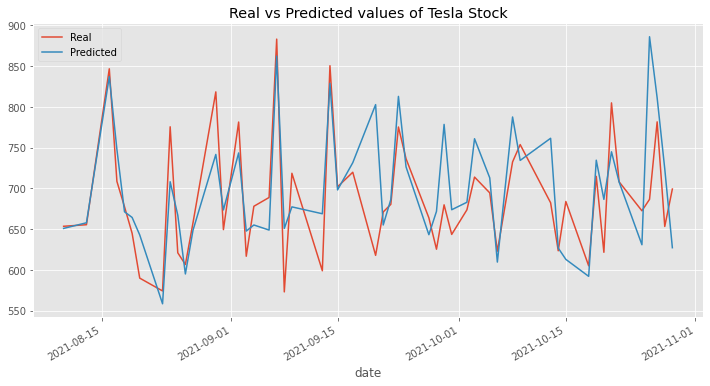

In [54]:
# Plot the real vs predicted values as a line chart
import matplotlib.pyplot as plt
stocks_1.plot(title = "Real vs Predicted values of Tesla Stock")

### Random Forest Model

In [47]:

# Create the Random Forest regressor instance
rf_model = RandomForestRegressor(n_estimators=1000, max_depth=2, bootstrap=False, min_samples_leaf=1)

In [48]:
# Fit the model
rf_model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=False, max_depth=2, n_estimators=1000)

In [49]:
# Make some predictions
RF_pred = rf_model.predict(X_test)

### Model EValuation:
    
* Using the X test and y test data, evaluate the model.<br>
* Make predictions based on the X test data.<br>
* Make a DataFrame with Real (y test) and Predicted (y test) values.<br>
* Make a line graph of the real vs. expected values.

In [50]:
# Evaluating the model
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, predicted)))
print('R-squared :', r2_score(y_test, predicted))

Root Mean Squared Error: 55.72430181881234
R-squared : 0.3820163267067429


In [51]:
# Create a DataFrame of Real and Predicted values
stocks_2 = pd.DataFrame({"Real": y_test.ravel(), "Predicted": RF_pred},
                     index = df2.index[-len(y_test): ]) 
stocks_2.head()

,Real,Predicted
date,,
2021-08-10,653.380005,682.052715
2021-08-13,655.289978,682.052715
2021-08-16,846.640015,776.024811
2021-08-17,708.489990,682.052715
2021-08-18,677.349976,682.052715


<AxesSubplot:title={'center':'Real vs Predicted values of TESLA'}, xlabel='date'>

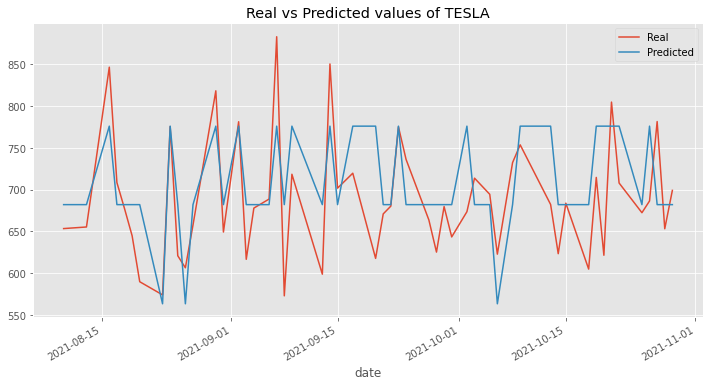

In [55]:
# Plot the real vs predicted values as a line chart
stocks_2.plot(title = "Real vs Predicted values of TESLA")

<center><h2> THE END